In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels
import scipy
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats
import pylab
import matplotlib as mpl
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
sns.set()

In [2]:
raw_index_data=pd.read_csv('Index2018.csv')  # Index price data Importation in Raw_index_data variable
df_index=raw_index_data.copy()  # copy to df_index from Raw_index_data
df_index.date=pd.to_datetime(df_index.date,dayfirst=True) # datatype of date column changed to datetime 
df_index.set_index('date',inplace=True) # set date column as index
df_index=df_index.asfreq('b') # setting frequency of data obsevation to business days
df_index.shape #shape checking 

(6277, 4)

In [3]:
df_index.spx.fillna(method='ffill',inplace=True) # front filling of missing values of spx columns
df_index.ftse.fillna(method='bfill',inplace=True) # backfilling of missing values of ftse columns
df_index.dax.fillna(df_index.dax.mean(),inplace=True) # mean value assigned to each missing values of dax columns 
df_index.nikkei.fillna(df_index.nikkei.median(),inplace=True) # median value assigned to each missing value of nikkei

In [4]:
df_market_value=df_index[['ftse']] # Selecting FTSE index for further processing
df_market_value.rename(columns={'ftse':'market_value'},inplace=True) # renaming ftse to market value
traininglen=int(len(df_market_value)*0.8) # Train and test split with ratio of 80:20
testingLen=len(df_market_value)-traininglen
df_market_value_train=df_market_value.iloc[:traininglen,:]
df_market_value_test=df_market_value.iloc[traininglen:,:]

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
mean=df_market_value_train['market_value'].mean() # calculating mean of ftse market index values from training part of dataset
std=df_market_value_train['market_value'].std() # calculating std from same
wn=np.random.normal(loc=mean,scale=std,size=len(df_market_value_train)) # creating white noice using np.random.uniform()
df_market_value_train['wn']=wn 

C:\Users\adadi\AppData\Local\Temp/ipykernel_19156/2511373873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_value_train['wn']=wn


In [6]:
rw=pd.read_csv('RandWalk.csv') # adding new column for random walk in training dataframe  
rw.date=pd.to_datetime(rw.date,dayfirst=True)
rw.set_index('date',inplace=True)
df_market_value_train=pd.merge(left=df_market_value_train,right=rw,left_index=True, right_index=True)
df_market_value_train.rename(columns={'price':'rw'},inplace=True) # renaming the randomwalk value column

In [7]:
df_market_value_train.head()

,market_value,wn,rw
date,,,
1994-01-07,3445.98,4680.022314,1122.139662
1994-01-10,3440.58,3957.268606,1080.347860
1994-01-11,3413.77,5430.339069,1082.095245
1994-01-12,3372.02,6888.740315,1083.639265
1994-01-13,3360.01,5039.763284,1067.146255


## ***SARIMAX***
- Seaonality occuar when certain pattern are not consistent but repeated peridically.
- Trend componet hold value which are period apart.
- But seaonal component hold value which occuar a season apart, that season can be anything like 12 month, quarter, 24hours, 60 minute. it depends on data we are dealing with.
- Let take an example in every dusehera people like to buy new clothes. Sales can be expected to be increased around this occasion. but if we will normal arimax model then it will underestimate actual sale number by considering sales pattern of past couple of month. And this normal arima model can alos overestimate the number of sale after this month if it will considerd the sales pattern that would have obatined in dushera month. So in this kind of cases where a specific time in an year matter, in this case seasonality component is require to handel this scenoario.
- This seasonality component nothing but combination of coefficient and past value that has occuared season ago.  Const*X(t-s)
- To deal with this kind of data SARIMAX Is used. which incorporate a order of 4 values (P,D,Q,s).
- Where
  - P: It is bascially a seasonal variation of autoregression parameter. suggest that how many last seasonal value model should considerd to take into account of future prediciton.
  - D: Number of Seaonal integration model require to make the data stationary.
  - Q: It is also seasonal variation of moving average parameter value. suggest that how many last residual error occuar at lags which are present at certain no of season away.
  - s: It is length of the season.
- Lets take a model to interpret all the parameter values

### SARIMAX(order=(1,0,2),seasonal_order=(2,0,1,5))
- p=1
- d=0
- q=2
- P=2
- D=0
- Q=1
- s=5
- In this model there would be total 6 no of unique coefficient exist.
- Here in autoregressive componet will consider the value at only last period, since order[0] value is 1.
- moving average component will consider error that occuar in last two lags, since order[2] vauee is 2.
- seasonal length is 5.
- since season_order[0] value is 2 here it means that value that occur at t-5, t-10 will be considered for each prediction of current value.
- since season_order[2] value is 1 so residual that obtained at t-5 lag will be consider for each prediction of current value.
- since d and D value are 0, so integration would be performed here.
- The equation of sarimax would look like this
- for example if order(1,0,0) and seasonal_order(2,0,0,10)
- 𝑋𝑡 = 𝐶 + 𝜙1*𝑋𝑡−1 + 𝜙10*𝑋𝑡−10 + 𝜙11*𝑋𝑡−11 + 𝜙20*𝑋𝑡−20 + 𝜙21*𝑋𝑡−21 + 𝜖t
- Since the value of p=1 and P=2. so usually in the equation value at t-10,t-11 and t-20,t-21 is considered. two seasonal distance and along with their previous lag is also considered.
- However, the values for 𝜙11 and 𝜙21 are restricted. They must be equal to 𝜙1*𝜙10 and 𝜙1*𝜙20 respectively
- So modified uquation would be
- 𝑋𝑡 = 𝐶 + 𝜙1𝑋𝑡−1 + 𝜙10𝑋𝑡−10 + 𝜙1𝜙10𝑋𝑡−11 + 𝜙20𝑋𝑡−20 + 𝜙1𝜙20𝑋𝑡−21 + 𝜖t
- by rewriting the equation we can find that.
- 𝑋𝑡 = 𝐶 + 𝜙1𝑋𝑡−1 + 𝜙10(𝑋𝑡−10 + 𝜙1𝑋𝑡−11) + 𝜙20(𝑋𝑡−20 + 𝜙2𝑋𝑡−21) + 𝜖t
- For consistency, we like to use distinct notation for the seasonal coefficients as well, so we plug in Φ1 and Φ2 for 𝜙10 
and 𝜙2.
- 𝑋𝑡 = 𝐶 + 𝜙1𝑋𝑡−1 + Φ1(𝑋𝑡−10 + 𝜙1𝑋𝑡−11) + Φ2(𝑋𝑡−20 + 𝜙2𝑋𝑡−21) + 𝜖t
- If we include residual then equation would like this
- let order: (1,0,2) and seasonal order:(2,0,1,10). in this case equation would like.
- 𝑋𝑡 = 𝐶 + 𝜙1𝑋𝑡−1 + 𝜃1𝜖𝑡−1 + 𝜃2𝜖𝑡−2 + 𝜙10𝑋𝑡−10 + 𝜙11𝑋𝑡−11 + 𝜙20𝑋𝑡−20 + 𝜙21𝑋𝑡−21 
+ 𝜃10𝜖𝑡−10 + 𝜃11𝜖𝑡−11 + 𝜃12𝜖𝑡−12 + 𝜖�
- the coefficients 𝜃11 and 𝜃12 are restricted too and equal 𝜃10 𝜃1 and 𝜃10𝜃2 respectively. We can once again 
plug in and substitute a few thing.
- 𝑋𝑡 = 𝐶 + 𝜙1𝑋𝑡−1 + 𝜃1𝜖𝑡−1 + 𝜃2𝜖𝑡−2 + Φ1 𝑋𝑡−10 + 𝜙1𝑋𝑡−11 + Φ2 𝑋𝑡−20 + 𝜙1𝑋𝑡−21 + Θ1(𝜖𝑡−10 + 𝜃1𝜖𝑡−11 + 𝜃2𝜖𝑡−12) + 𝜖t
- Additionally, we have to include more past values because if the value from yesterday affects the value today, then 
the value from 11 days ago affects the one from 10 days ago. This is the entire reason we’re not only including 𝑋𝑡−10 
𝑋𝑡−20 and 𝜖𝑡−10 in the model, but also the values that shape the.�
0

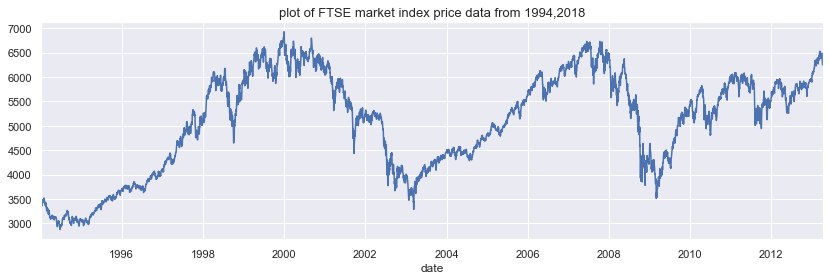

In [9]:
plt.figure(figsize=(14,4))
df_market_value_train.market_value.plot()
plt.title('plot of FTSE market index price data from 1994,2018',size=13)
plt.show()

#### SARIMAX(order(1,0,1),seasonalorder=(2,0,1,5))

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
model_sarimax = SARIMAX(df_market_value_train.market_value,exog=df_index.iloc[0:df_market_value_train.shape[0],0],order=(1,0,1),seasonal_order = (2,0,1,5))
result_sarimax=model_sarimax.fit()
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26719.403
Date:                           Sat, 26 Oct 2024   AIC                          53452.807
Time:                                   20:30:02   BIC                          53498.456
Sample:                               01-07-1994   HQIC                         53468.803
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7004      0.036     75.909      0.000       2.631       2.770
ar.L1          0.9998      0.001   1807.554      0.000       0.999       1.001
ma.L1         -0.3117      0.010    -32.518      0.000      -0.330      -0.293
ar.S.L5        0.9641      0.012     81.550      0.000       0.941       0.987
ar.S.L10       0.0355      0.006      5.530      0.000       0.023       0.048
ma.S.L5       -0.9994      0.011    -93.690      0.000      -1.020      -0.978
sigma2      2449.7140     28.730     85.265      0.000    2393.403    2506.025
===================================================================================
Ljung-Box (L1) (Q):                   1.55   Jarque-Bera (JB):              4116.71
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Volatitliy
- lets explain what is valatility
- For a long term huge purchase of stocks invester need stability in market so they can invest with out taking huge risk.
- The longer the time portafolio maintains stability the more the invester would like to invest in the stocks of same portfolio.
- Volatility can be also considered as variance.
- This voloitility is affected by unexpected change in price .
- But in the context of Volatility it doesnot matter that sign of the sudden change in negative or positive. and these are equally unpleasant.
- It only depend upon magnitude of the sudden change.
- So to calculate to volatity accurately we have go through three steps.
  - solves positive and negative conundrum.
  - we square the values.
  - penalize high difference between prediction and actual.
  - increase importance of high big unpredictable shocks.
- So to calculate volatity we use ARCH which is in next notebook.